In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from astropy.io import fits # Astropy for FITS files

# Custom functions
from cosmoforests.io import get_qso_data, get_docs_path
from cosmoforests.mask_forest import mask_forest
from cosmoforests.statistics import get_statistics

# Plot style
sns.set_theme()

# Data Directory (customize this)
data_dir = 'data/raw'

In [2]:
# Get the path to the FITS files in the data directory
fits_path = get_docs_path(data_dir)

Number of .fits files = 703
Path example: data/raw/13/1395/transmission-16-1395.fits.gz


## Working with only one .fits file

In [3]:
# Read in the first FITS file
hdul = fits.open(fits_path[0])

# File information
hdul.info()

# Close the FITS file
hdul.close()

Filename: data/raw/13/1395/transmission-16-1395.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  METADATA      1 BinTableHDU     23   3644R x 5C   [E, E, E, E, K]   
  2  WAVELENGTH    1 ImageHDU        11   (15150,)   float32   
  3  F_LYA         1 ImageHDU        12   (15150, 3644)   float32   
  4  F_LYB         1 ImageHDU        13   (15150, 3644)   float32   
  5  F_METALS      1 ImageHDU        14   (15150, 3644)   float32   
  6  DLA           1 BinTableHDU     23   1885R x 5C   [D, D, D, K, K]   


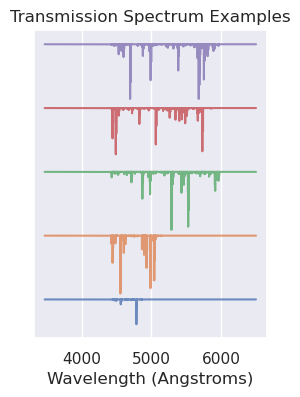

In [4]:
# Read in the first FITS file
z, wv, fluxes = get_qso_data(fits_path[0])

n_bins = len(wv)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

for i in range(5):
    ax.plot(wv, fluxes[i] + 1.1*i, alpha = 0.8)

ax.set_xlabel('Wavelength (Angstroms)')
# Remove the y-axis ticks and labels
ax.set_yticks([])
ax.set_yticklabels([])

# Plot title
ax.set_title('Transmission Spectrum Examples')

plt.show()

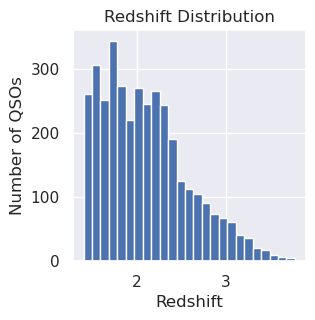

In [5]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.hist(z, bins = 25)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of QSOs')

ax.set_title('Redshift Distribution')
plt.show()

In [6]:
# Mask the flux data to a given wavelength range. Default to CIV forest.
fluxes = mask_forest(z, wv, fluxes)

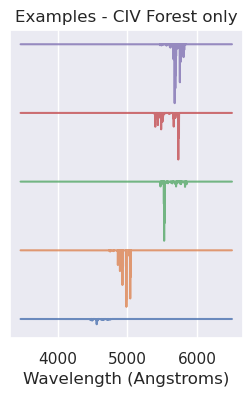

In [7]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

for i, flux in enumerate(fluxes[0:5]):
    ax.plot(wv, flux + 1.1*i, alpha = 0.8)

ax.set_xlabel('Wavelength (Angstroms)')
# Remove the y-axis ticks and labels
ax.set_yticks([])
ax.set_yticklabels([])

# Plot title
ax.set_title('Examples - CIV Forest only')

plt.show()

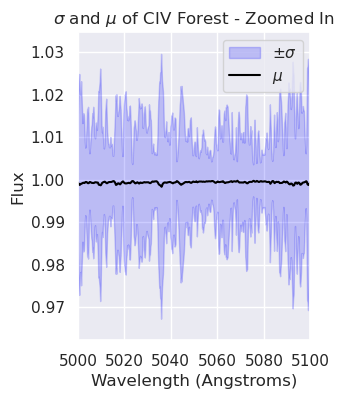

In [8]:
# Get statistics for the transmission files.
mean, std, deltas = get_statistics(fluxes, get_deltas = True)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

# Plot standard deviation
ax.fill_between(wv, mean - std, mean + std,
                alpha = 0.2, color = 'blue',
                label = '$\pm \sigma$')

# Plot mean
ax.plot(wv, mean, alpha = 1, color = 'black',
        label = '$\mu$')

# Zoom in on the CIV forest
ax.set_xlim(5000, 5100)

# Labels
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux')
ax.set_title('$\sigma$ and $\mu$ of CIV Forest - Zoomed In')

# Show legend
ax.legend()

plt.show()

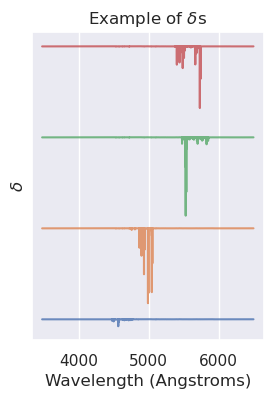

In [9]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(3, 4))

for i, delta in enumerate(deltas[0:4]):
    ax.plot(wv, delta + 1.1*i, alpha = 0.8)

ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('$\delta$')

# Remove the y-axis ticks and labels
ax.set_yticks([])
ax.set_yticklabels([])

# Plot title
ax.set_title('Example of $\delta$s')

plt.show()

## Working with multiple .fits files

At the end, we would want to have a single array with the mean from all the files, and also a delta array for every file. One problem is that we cannot load all the data into memory at once and then calculate the mean, because the data is too big. We need to calculate the mean as we go along, and then save the delta arrays.

If we have two datasets with size $n_1$ and $n_2$, with mean $\mu_1$ and $\mu_2$, and $\sigma_1$ and $\sigma_1$, then the mean and standard devaition of the combined dataset are:

$$\mu_c = \frac{n_1 \mu_1 + n_2 \mu_2}{n_1 + n_2}$$

$$\sigma_c^2 = \frac{n_1[\sigma_1^2 + (\mu_1 - \mu_c)^2] + n_2[\sigma_2^2 + (\mu_2 - \mu_c)^2]}{n_1 + n_2}$$

In [10]:
# Number of .fits files
n_files = len(fits_path)

# Number of bins
n_bins = len(wv)

# Initialize arrays to store the statistics
mean = np.zeros((n_files, n_bins))
std = np.zeros((n_files, n_bins))
n_qso = np.zeros(n_files)

In [11]:
# Loop over the files

i = 0
for path in tqdm(fits_path):
    # Get the data
    z, wv, fluxes = get_qso_data(path)

    # Mask the flux data to a given wavelength range. Default to CIV forest.
    fluxes = mask_forest(z, wv, fluxes)

    # Get statistics for the transmission files.
    mean[i], std[i] = get_statistics(fluxes, get_deltas = False)

    # Number of QSOs in the file
    n_qso[i] = len(z)

    # Increment the counter
    i += 1

100%|██████████| 703/703 [1:06:06<00:00,  5.64s/it]


In [12]:
# Compute the overall mean

total_mean = np.zeros(n_bins)
total_qsos = np.sum(n_qso)

for i in range(n_files):
    total_mean += mean[i] * n_qso[i]

total_mean /= total_qsos

In [13]:
# Compute the overall standard deviation

total_std = np.zeros(n_bins)

for i in range(n_files):
    total_std += n_qso[i] * (std[i]**2 + (mean[i] - total_mean)**2)

total_std = np.sqrt(total_std / total_qsos)

In [14]:
# Save the data to a .csv file
# df = pd.DataFrame({'wv': wv, 'mean': total_mean, 'std': total_std})
# df.to_csv('data/processed/mean_std.csv', index = False)

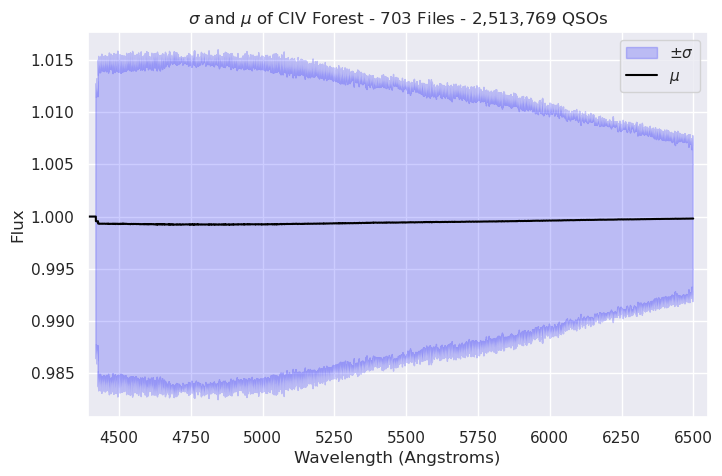

In [20]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Plot standard deviation
ax.fill_between(wv, total_mean - total_std, total_mean + total_std,
                alpha = 0.2, color = 'blue',
                label = '$\pm \sigma$')

# Plot mean
ax.plot(wv, total_mean, alpha = 1, color = 'black',
        label = '$\mu$')

# Zoom in on the CIV forest
ax.set_xlim(4390, 6550)
#ax.set_xlim(5000, 5100)

# Labels
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux')
ax.set_title(f'$\sigma$ and $\mu$ of CIV Forest - {n_files} Files - {int(total_qsos):,} QSOs')

# Show legend
ax.legend()

plt.show()

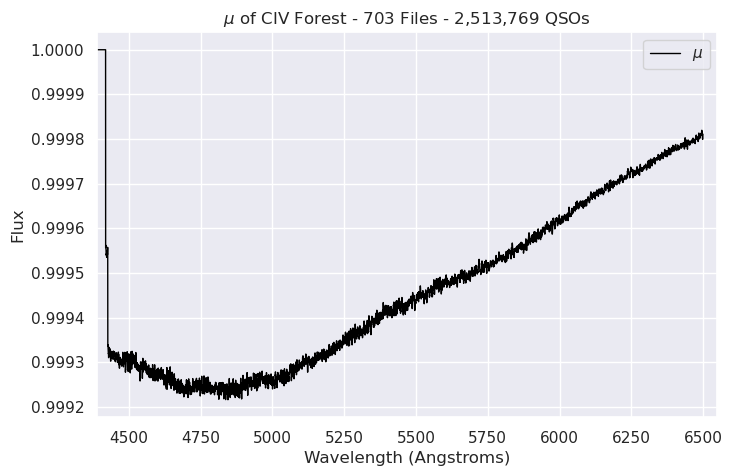

In [28]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Plot mean
ax.plot(wv, total_mean, alpha = 1, color = 'black',
        label = '$\mu$', linewidth = 1)

# Zoom in on the CIV forest
ax.set_xlim(4390, 6550)
#ax.set_xlim(5000, 5100)

# Labels
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux')
ax.set_title(f'$\mu$ of CIV Forest - {n_files} Files - {int(total_qsos):,} QSOs')

# Show legend
ax.legend()

plt.show()